# Noise in quantum algorithms
Today we want to do a simulation of the GHZ. First we implement an ideal simulation, then we add some noise and, lastly, we compare the results with the ones that we obtain running the algorithm on a real machine.
GHZ performes the following operation:

$$
|0\rangle^{\otimes m}\overset{GHZ}{\longrightarrow}\frac{1}{\sqrt{2}}\left(|0\rangle^{\otimes m} + |1\rangle^{\otimes m}\right)
$$

and we implement it using an Hadamard gate and some CNOT gates.

We start by writing a function that returns the circuit which implements the GHZ given a number of qubits.

In [50]:
from qiskit import QuantumCircuit
from qiskit.providers.aer import AerSimulator # We use it both in the ideal and noisy simulations
from qiskit.visualization import plot_histogram, plot_gate_map # To see how the backend is mapped
from qiskit import transpile
from jupyterthemes import jtplot
jtplot.style(theme = 'monokai', context = 'notebook', ticks = True, grid = False)

In [51]:
from qiskit import IBMQ

if not IBMQ.active_account():
    if not IBMQ.stored_account():
        with open('Token') as file:
            token = file.readline()

        IBMQ.save_account(token)

    IBMQ.load_account()

backends = IBMQ.providers()[0].backends()
info = backends[-1]

In [52]:
provider = IBMQ.get_provider(hub = info.hub, group = info.group, project = info.project)
backend = provider.get_backend(info.name())

In [53]:
def GHZ(n):
    '''
    Creates the GHZ circuit with a number `n` of QUBITs.
    '''
    circuit = QuantumCircuit(n, n)
    circuit.h(0) # Hadamard gate one the first QUBIT
    
    for i in range(1, n):
        circuit.cx(0, i) # CNOT between the fisrt and each of the following qubits
        
    circuit.barrier(range(n)) # Needed to distinguish between computation and measures
    circuit.measure(range(n), range(n)) # Measure for each QUBIT
    # Alternatively, use the method `circuit.measure_all()` where `circuit = QuantumCircuit(n)`
    
    return circuit

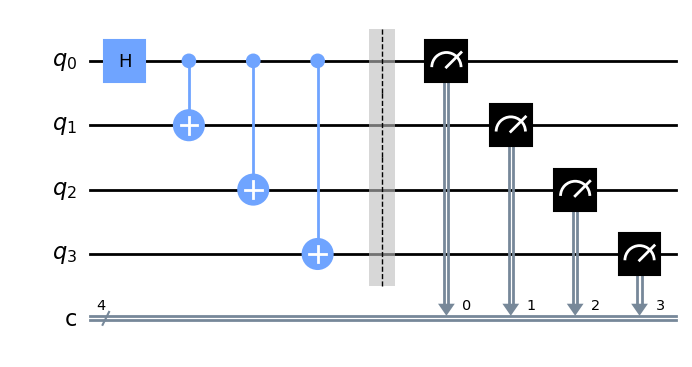

In [54]:
circuit = GHZ(4)
circuit.draw('mpl')

Now, with the circuit thus implemented, we can run an ideal simulation. However, it will not work on an IBM device: we must first transpile it. Transpiling the circuit means turning it into an equivalent circuit that is implemented with the gates provided by a real machine at hardware level, which are limited in number. 

For example, the IBM device doesn't provide the Hadamard gate, but some other gates that can be combined to implement it. This gates are:

$$
\left\{X, SX, CX, R_Z, I\right\}
$$

where $SX\cdot SX = X$. These gates are used to implement whichever algorithm we write. In particular, when we add noise, we have to take this fact into account.

Note that the $R_Z$ gate is a virtual gate, that is with zero error and duration (indeed whenever appears a $R_Z(\phi)$ gate in our circuit we can obtain the same result, with an additional phase which does not change the probability, simply by applying a phase displacemente of $-\phi$ to all the subsequents gates). Thus the noise is applied only on the $X$, $CX$ and $SX$ gates.

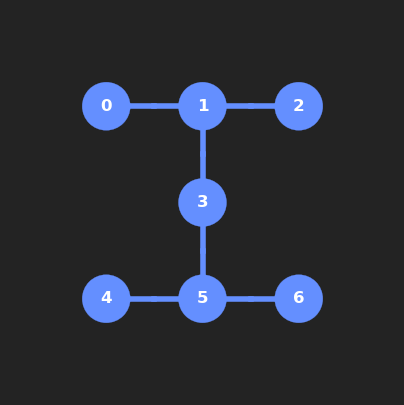

In [55]:
plot_gate_map(backend) # To visualize the backend hardware map

In [56]:
qubits_layout = [0, 1, 3, 5] # We have to choose which qubits to use

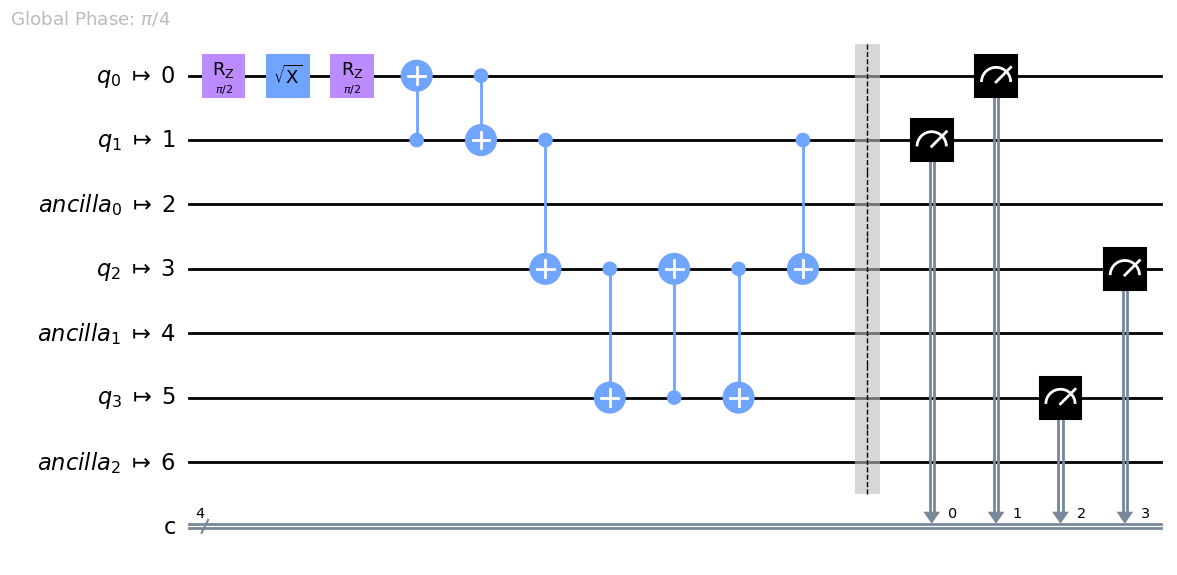

In [57]:
transpiled_circuit = transpile(circuit, backend, initial_layout = qubits_layout, seed_transpiler = 42)
transpiled_circuit.draw('mpl')

In the traspiled circuit we can observe how qiskit optimized our circuit. In particular, we notice that it added some $CX$, why?

Consider, for example, the qubits $q_0$ and $q_3$. These are respectively mapped in 0 and 5: by looking at the map we can see that these two nodes are not connected. Since they are not connected we can't implement two-qubits gates between them. Thus during the transpile some swap gates are added.

Moreover, we can notice how the transpile does not swap back but, instead, it properly shifts the measures. This is done because swapping back is a costly operation.

Note that a swap gate is implemented by 3 $CX$ gates of which the middle one is flipped (by adding a barrier between each gate in the not transpiled circuit one can clearly see them because that way qiskit is not allowed to perform any optimization).

In [72]:
# Running the ideal simulation
max_qubits = 5
shots = 1000
qubits_layout = [0, 1, 3, 5, 4]
counts_ideal = []

for i in range(2, max_qubits + 1):
    circuit = GHZ(i)
    circuit = transpile(circuit, backend, initial_layout = qubits_layout[:i], seed_transpiler = 42)
    sim = AerSimulator(method = 'statevector') # We perform the simulation using state vectors
    job = sim.run(circuit, shots = shots)
    result = job.result()
    counts = result.get_counts()
    counts_ideal.append(counts)

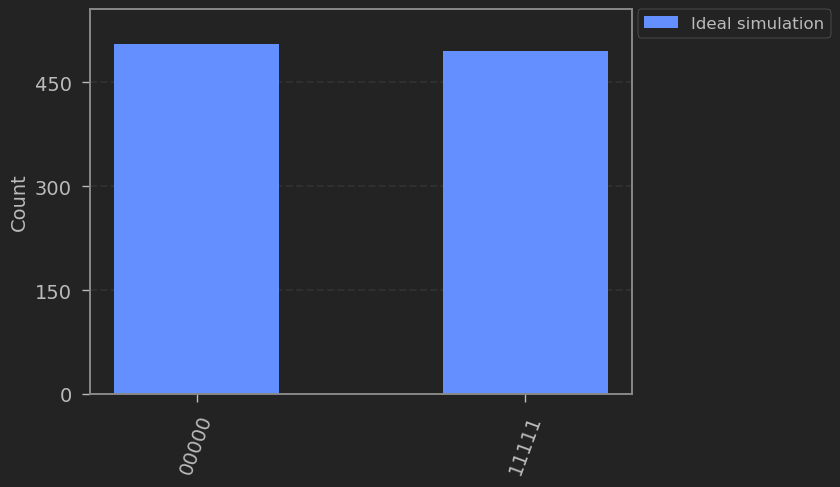

In [73]:
# See histograms 
i = 5
legend = ['Ideal simulation']
plot_histogram([counts_ideal[i - 2]], bar_labels = False, legend = legend)

Now we want to add the noise.

Note that if the operators of the Kraus map are unitary then we only need to know the probability in order to apply a noise channel. If the operators are not unitary then we also need to know the state.

In [81]:
# Import libraries for Noise (`pauli_error` describes the bit-flip error)
from qiskit.providers.aer.noise import NoiseModel, pauli_error, depolarizing_error, phase_amplitude_damping_error

In [85]:
# Example of noise channel definition
p = 4 / 3 # The term with the identity is not considered with this probability
depolarization = depolarizing_error(p, 1) # Takes the probability and the number of qubits
print(depolarization)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.3333333333333333, Circuit = 
   ┌───┐
q: ┤ X ├
   └───┘
  P(1) = 0.3333333333333333, Circuit = 
   ┌───┐
q: ┤ Y ├
   └───┘
  P(2) = 0.3333333333333333, Circuit = 
   ┌───┐
q: ┤ Z ├
   └───┘


In [86]:
spam = pauli_error([('X', 10e-2), ('I', 1 - 10e-2)]) # Bit-flip
print(spam)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.1, Circuit = 
   ┌───┐
q: ┤ X ├
   └───┘
  P(1) = 0.9, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘


In [87]:
# How to compose errors: first occurs a type of error and then another on the same qubit
error_composed = depolarization.compose(spam)
print(error_composed)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.03333333333333333, Circuit = 
   ┌───┐┌───┐
q: ┤ X ├┤ X ├
   └───┘└───┘
  P(1) = 0.3, Circuit = 
   ┌───┐┌───┐
q: ┤ X ├┤ I ├
   └───┘└───┘
  P(2) = 0.03333333333333333, Circuit = 
   ┌───┐┌───┐
q: ┤ Y ├┤ X ├
   └───┘└───┘
  P(3) = 0.3, Circuit = 
   ┌───┐┌───┐
q: ┤ Y ├┤ I ├
   └───┘└───┘
  P(4) = 0.03333333333333333, Circuit = 
   ┌───┐┌───┐
q: ┤ Z ├┤ X ├
   └───┘└───┘
  P(5) = 0.3, Circuit = 
   ┌───┐┌───┐
q: ┤ Z ├┤ I ├
   └───┘└───┘


In [89]:
# How to get tensor product of two noise channels
composed = spam.tensor(spam)
print(composed)

QuantumError on 2 qubits. Noise circuits:
  P(0) = 0.010000000000000002, Circuit = 
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
  P(1) = 0.09000000000000001, Circuit = 
     ┌───┐
q_0: ┤ I ├
     ├───┤
q_1: ┤ X ├
     └───┘
  P(2) = 0.09000000000000001, Circuit = 
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ I ├
     └───┘
  P(3) = 0.81, Circuit = 
     ┌───┐
q_0: ┤ I ├
     ├───┤
q_1: ┤ I ├
     └───┘


In [95]:
damping = phase_amplitude_damping_error(0.2, 0.1)
print(damping)
# In this case the Kraus operators are not unitary, thus Qiskit will have to look at the state in 
# order to understand which Kraus operator to apply

QuantumError on 1 qubits. Noise circuits:
  P(0) = 1.0, Circuit = 
   ┌───────┐
q: ┤ kraus ├
   └───────┘


Now we want to write a function that inserts typical IBM platform noises. We use it in `AerSimulator`. The typical superconducting IBM devices noises. The simplest model presenting the typical noises of IBM superconducting devices implements:
 - depolarization and relaxation errors after the single-qubit and two-qubits gates,
 - a bit-flip error before measurement.
 
The idea is to create a function which takes a given backend as input. The backend provides some noise parameters that we use as inputs to the errors defined above.

In [25]:
# IBM noise model for qiskit with depolarization, relaxation after gates and bit-flip before 
# measurements
from numpy import zeros

def IBM_noise_model(backend, layout):
    tg = 35 * 10e-9
    n = len(layout)
    noise = NoiseModel()
    properties = backend.properties()
    tcnot = zeros((n, n))
    pcnot = zeros((n, n))
    
    # Read from backend
    t1 = [properties.t1(j) for j in layout]
    t2 = [properties.t2(j) for j in layout]
    p = [properties.gate_error('x', [j]) for j in layout]
    rout = [properties.readout_error(j) for j in layout]

    if n > 1:
        tcnot[0][1] = prop.gate_length('cx', [layout[0], layout[1]])
        pcnot[0][1] = prop.gate_error('cx', [layout[0], layout[1]])
        tcnot[-1][-2] = prop.gate_length('cx',[layout[-1], layout[-2]])
        pcnot[-1][-2] = prop.gate_error('cx',[layout[-1], layout[-2]])

        for i in range(1, n - 1):
            tcnot[i][i - 1] = prop.gate_length('cx', [layout[i], layout[i - 1]])
            pcnot[i][i - 1] = prop.gate_error('cx', [layout[i], layout[i - 1]])
            tcnot[i][i + 1] = prop.gate_length('cx', [layout[i], layout[i + 1]])
            pcnot[i][i + 1] = prop.gate_error('cx', [layout[i], layout[i + 1]])

    for j in range(n):
        # Single qubit depolarizing
        depolarization = depolarizing_error(p[j], 1)
        
        # Single qubit relaxation
        tph = t1[j] * t2[j] / (2 * t1[j] - t2[j])
        p1 = 1 - exp(-tg / t1[j])
        pph = 1 - exp(-tg / tph)
        pz = (1 - p1) * pph
        relaxation = phase_amplitude_damping_error(p1, pz)
        
        # Spam
        spam = pauli_error([('X',rout[j]), ('I', 1 - rout[j])])
        
        # Adding errors to noise model
        single_qubit_gate_error = depolarization.compose(relax)
        noise_model.add_quantum_error(single_qubit_gate_error, ["x","sx"], [layout[j]])
        noise_model.add_quantum_error(spam, "measure", [layout[j]])
        
        value = []
        
        if j != 0:
            value += [j - 1]
        elif j != n:
            value += [j + 1]

        for k in values:
                # Two qubits relaxation
                tphj = t1[j] * t2[j] / (2 * t1[j] - t2[j])
                p1j = 1 - exp(-tcnot[j][k] / t1[j])
                pphj = 1 - exp(-tcnot[j][k] / tphj)
                pzj = (1 - p1j) * pphj
                
                tphk = t1[k] * t2[k] / (2 * t1[k] - t2[k])
                p1k = 1 - exp(- tcnot[j][k] / t1[k])
                pphk = 1 - exp(- tcnot[j][k] / tphk)
                pzk = (1 - p1k) * pphk
        
                relaxationj = phase_amplitude_damping_error(p1j, pzj)
                relaxationk = phase_amplitude_damping_error(p1k, pzk)
                relaxjk = relax_k.tensor(relaxj)

                # Two qubits depolarizing
                dep_j = depolarizing_error(p_cnot[j][k],1)
                dep_k = depolarizing_error(p_cnot[j][k],1)
                dep_cnot = dep_k.tensor(dep_j) 
                
                # Adding errors to noise model
                
                two_qubits_gate_error = dep_cnot.compose(relax_jk)
                
                noise_model.add_quantum_error(two_qubits_gate_error, "cx",[qubits_layout[j],qubits_layout[k]])
    
    return noise_model

In [26]:
#RUN IBM noise simulation

max_nqubits = 5
shots = 1000
qubits_layout = [0,1,3,5,4]
counts_noise = []
for i in range(2,max_nqubits+1):
    qc = GHZ_circ(i)
    qc = transpile(qc, backend, initial_layout = qubits_layout[0:i], seed_transpiler=42)
    noise_model = IBM_noise_model(backend,qubits_layout)
    sim_noise = AerSimulator(noise_model=noise_model,method='statevector')
    job = sim_noise.run(qc,shots=shots)
    result = job.result()
    counts = result.get_counts()
    counts_noise.append(counts)

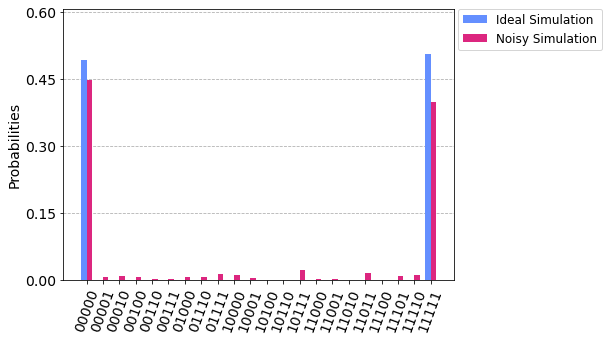

In [27]:
#See histograms 

i = 5

legend = ['Ideal Simulation','Noisy Simulation']

plot_histogram([counts_ideal[i-2],counts_noise[i-2]],bar_labels=False,legend=legend)

In [ ]:
#RUN ON ACTUAL HARDWARE

max_nqubits = 5
shots = 1000
qc_list = [None for i in range(0,max_nqubits-1)]
qubits_layout = [0,1,3,5,4]
counts_device = []
for i in range(2,max_nqubits+1):
    
    qc = GHZ_circ(i)
    qc_list[i-2] = transpile(qc, backend, initial_layout = qubits_layout[0:i],seed_transpiler=42)


job = backend.run(qc_list, shots=shots)
result = job.result()

for i in range(2,max_nqubits+1):
    
    counts = result.get_counts(qc_list[i-2])
    
    counts_device.append(counts)

In [ ]:
#See histograms 

i = 4

legend = ['Device','Ideal Simulation','Noisy Simulation']

plot_histogram([counts_device[i-2],counts_ideal[i-2],counts_noise[i-2]],bar_labels=False,legend=legend)